# 14. Проверка принадлежности параметрическому семейству

In [13]:
import sys
sys.path.append("/Users/PredatoryMink/Statistics")

import numpy as np
import pandas as pd
import math as mt
import scipy.stats as st
import scipy.optimize as opt
import scipy.special as sp
import scipy.optimize as opt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import namedtuple
from tqdm import tqdm
from mystats.utils import plot as myplot

### Задание 1

In [30]:
def CvM_stat(X, cdf):
    k, n = X.shape
    Y = np.sort(cdf(X), axis=1)
    sub = (2 * np.arange(1, n + 1) - 1) / (2 * n)
    sub = np.tile(sub, (k, 1))
    t = 1 / (12 * n) + np.sum((Y - sub) ** 2, axis=1)
    return t

In [31]:
def exp_mle_rv(X):
    if X.ndim == 1:
        loc = np.min(X)
        scale = np.mean(X - loc)
    elif X.ndim == 2:
        loc = np.min(X, axis=1)[:, np.newaxis]
        scale = np.mean(X - loc, axis=1)[:, np.newaxis]
    rv = st.expon(loc=loc, scale=scale)
    return rv

In [32]:
def CvM_exp_stat(X):
    rv = exp_mle_rv(X)
    return CvM_stat(X, rv.cdf)

In [124]:
def CvM_exp(X):
    rv = exp_mle_rv(X)
    stat = CvM_stat(X, rv.cdf)
    p_value = 1 - np.searchsorted(CvM, stat, side='right') / CvM.size
    return p_value

In [33]:
# K = 100_000
# N = 1_000
# X = st.expon().rvs(size=(K, N))
# CvM = np.sort(CvM_exp_stat(X))
# np.save('CvM_exp_stat', CvM)

In [34]:
CvM = np.load('CvM_exp_stat.npy')

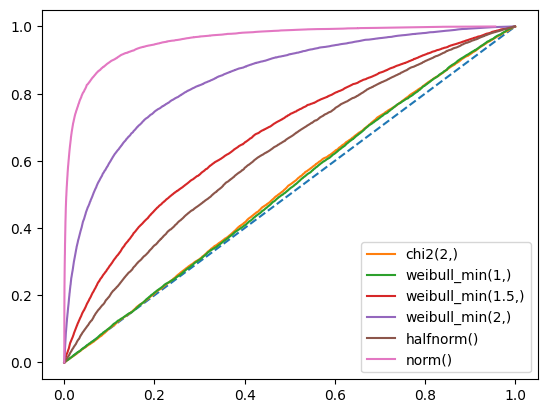

In [7]:
K = 10_000
N = 20
RVs = [st.chi2(2), st.weibull_min(1), st.weibull_min(1.5), st.weibull_min(2), st.halfnorm(), st.norm()]

plt.plot([0, 1], [0, 1], ls='dashed')
for rv in RVs:
    X = rv.rvs((K, N))
    t = CvM_exp_stat(X)
    p_value = 1 - np.searchsorted(CvM, t, side='right') / CvM.size
    plot.ecdf(p_value, label=f"{rv.dist.name}{rv.args}")
plt.legend();

### Задание 2

In [8]:
def get_freq(theta, bins):
    cdf = st.expon(loc=theta[0], scale=theta[1]).cdf
    y = np.r_[0, cdf(bins), 1]
    d = np.diff(y)
    return d

In [9]:
def negLnL(theta, bins, f_obs):
    d = get_freq(theta, bins)
    lnL = np.dot(f_obs, np.log(np.maximum(d, 1e-8)))
    return -lnL

In [10]:
def chisquare(x, bins):
    f_obs = np.bincount(np.digitize(x, bins), minlength=bins.size+1)
    loc0 = np.min(x)
    scale0 = np.mean(x - loc0)
    theta = opt.minimize(negLnL,
                         x0=[loc0, scale0],
                         args=(bins, f_obs),
                         bounds=((None, None), (1e-8, None))).x
    f_exp = N * get_freq(theta, bins)
    f_exp = np.maximum(f_exp, 1e-8)
    res = st.chisquare(f_obs, f_exp=f_exp, ddof=2)
    return res

100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.34it/s]


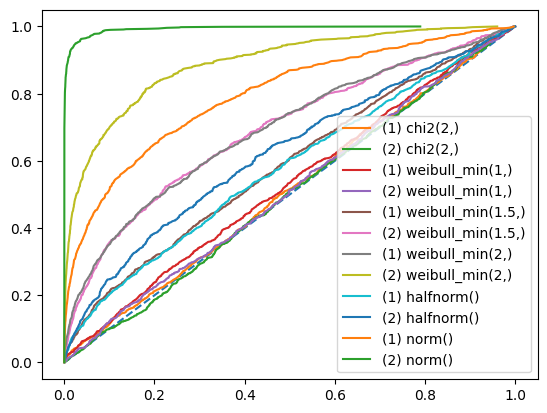

In [11]:
K = 1_000
N = 50
RVs = [st.chi2(2), st.weibull_min(1), st.weibull_min(1.5), st.weibull_min(2), st.halfnorm(), st.norm()]

plt.plot([0, 1], [0, 1], ls='dashed')
for rv in RVs:
    X = rv.rvs((K, N))
    p_value = np.zeros((2, K))
    for i in tqdm(range(K)):
        x = np.sort(X[i])
        nbins = max(3, int(max(mt.log(N, 2), N ** 0.2)))
        
        gsize = N // nbins
        bins = x[gsize : -gsize + 1 : gsize]
        p_value[0][i] = chisquare(x, bins).pvalue
        
        mle_rv = exp_mle_rv(x)
        alpha = 1 / nbins
        bins = mle_rv.ppf(alpha * np.arange(1, nbins))
        p_value[1][i] = chisquare(x, bins).pvalue
    for i in range(2):
        plot.ecdf(p_value[i], label=f"({i+1}) {rv.dist.name}{rv.args}")
plt.legend();

### Задание 3 

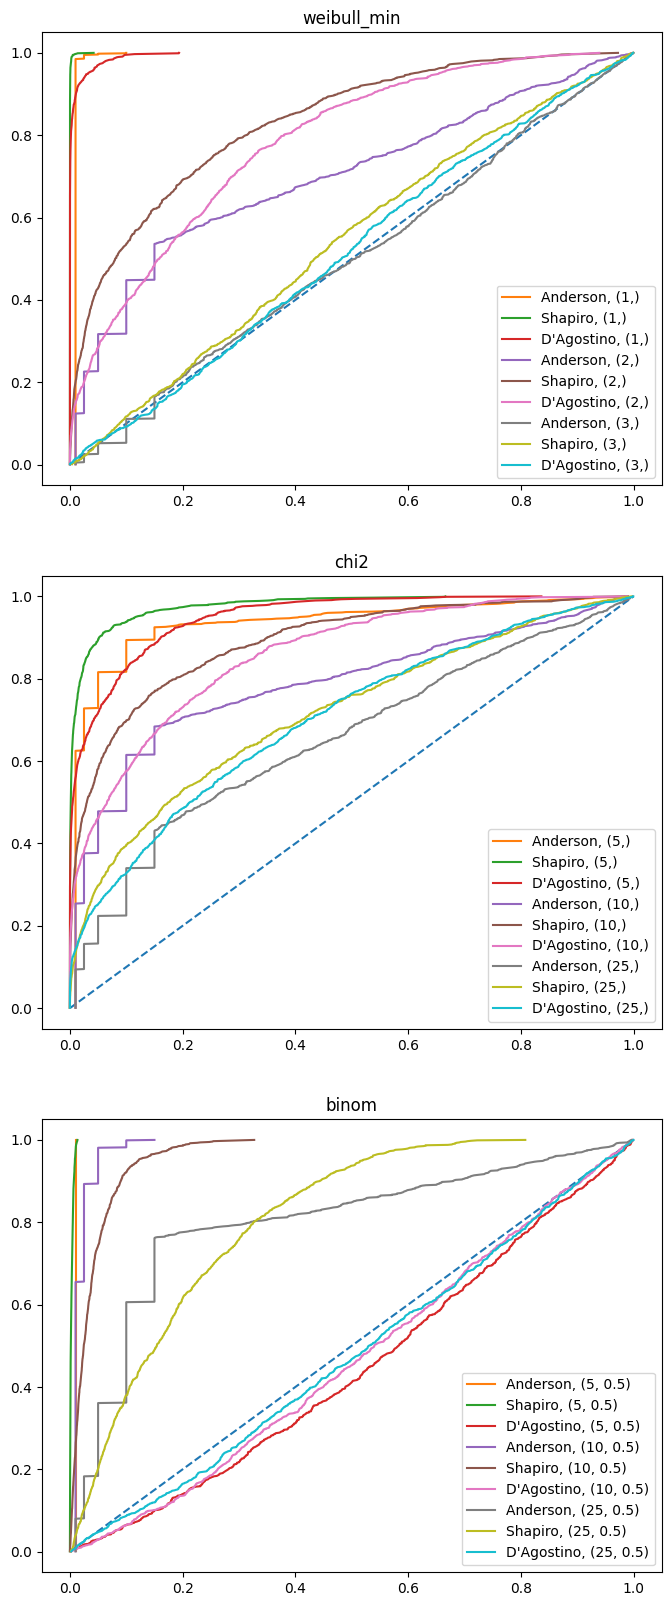

In [12]:
K = 1_000
N = 50
RV = [[st.weibull_min(k) for k in [1, 2, 3]],
      [st.chi2(k) for k in [5, 10, 25]],
      [st.binom(k, 1/2) for k in [5, 10, 25]]]

fig, axes = plt.subplots(3, 1, figsize=(8, 20))

for rvs, ax in zip(RV, axes):
    ax.plot([0, 1], [0, 1], ls='dashed')
    for rv in rvs:
        ax.set_title(rv.dist.name)
        X = rv.rvs((K, N))
    
        p_value = np.zeros(K)
        for i, x in enumerate(X):
            res = st.anderson(x)
            ind = np.searchsorted(res.critical_values, res.statistic, side='right')
            if ind == 0:
                p_value[i] = np.random.uniform(res.significance_level[0] / 100, 1)
            else:
                p_value[i] = res.significance_level[ind - 1] / 100
        plot.ecdf(p_value, ax, label=f"Anderson, {rv.args}")
    
        p_value = st.shapiro(X, axis=1).pvalue
        plot.ecdf(p_value, ax, label=f"Shapiro, {rv.args}")
        
        p_value = st.normaltest(X, axis=1).pvalue
        plot.ecdf(p_value, ax, label=f"D'Agostino, {rv.args}")
    ax.legend()

### Задание 4

In [144]:
def zhang_a_stat(X, cdf):
    k, n = X.shape
    Y = np.sort(cdf(X), axis=1)
    Y = np.clip(Y, 1e-9, 1 - 1e-9)
    coef = np.arange(0.5, n, 1)
    stat = -(np.log(Y).dot(1 / (n - coef)) + np.log(1 - Y).dot(1 / coef))
    return stat

In [145]:
def zhang_a(X, K=10_000):
    k, n = X.shape

    monte_carlo = st.expon().rvs(size=(K, n))
    rv = exp_mle_rv(monte_carlo)
    ZA = zhang_a_stat(monte_carlo, rv.cdf)
    ZA = np.sort(ZA)
    
    rv = exp_mle_rv(X)
    stat = zhang_a_stat(X, rv.cdf)
    p_value = 1 - np.searchsorted(ZA, stat, side='right') / K
    return p_value

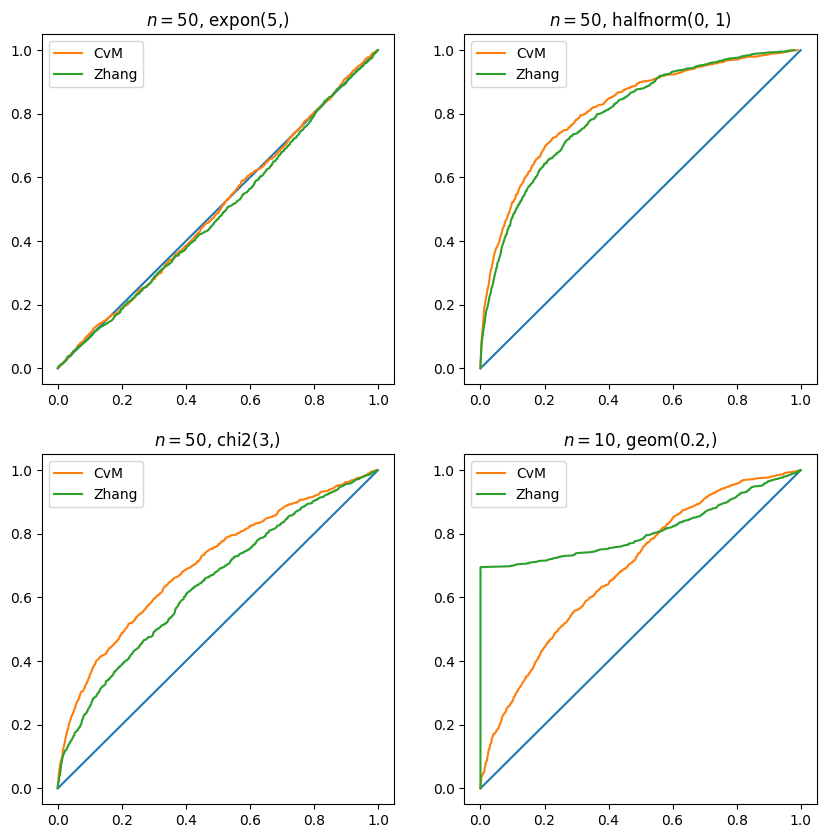

In [146]:
RVs = [st.expon(5), st.halfnorm(0, 1), st.chi2(3), st.geom(0.2, loc=0)]
Ns = [50, 50, 50, 10]
K = 1000

ncols = 2
nrows = len(Ns) // ncols + (1 if len(Ns) % ncols else 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))

for rv, n, ax in zip(RVs, Ns, axes.ravel()):
    ax.set_title(fr"$n = {n}$, {rv.dist.name}{rv.args}")
    ax.plot([0, 1], [0, 1])
    X = rv.rvs((K, n))
    pval = CvM_exp(X)
    myplot.ecdf(pval, ax, label=f"CvM")
    pval = zhang_a(X)
    myplot.ecdf(pval, ax, label=f"Zhang")
    ax.legend();

In [147]:
class AbsNorm:
    def __init__(self, loc=0, scale=1):
        self.rv = st.norm(loc, scale)

    def rvs(self, shape=None):
        return np.abs(self.rv.rvs(shape))

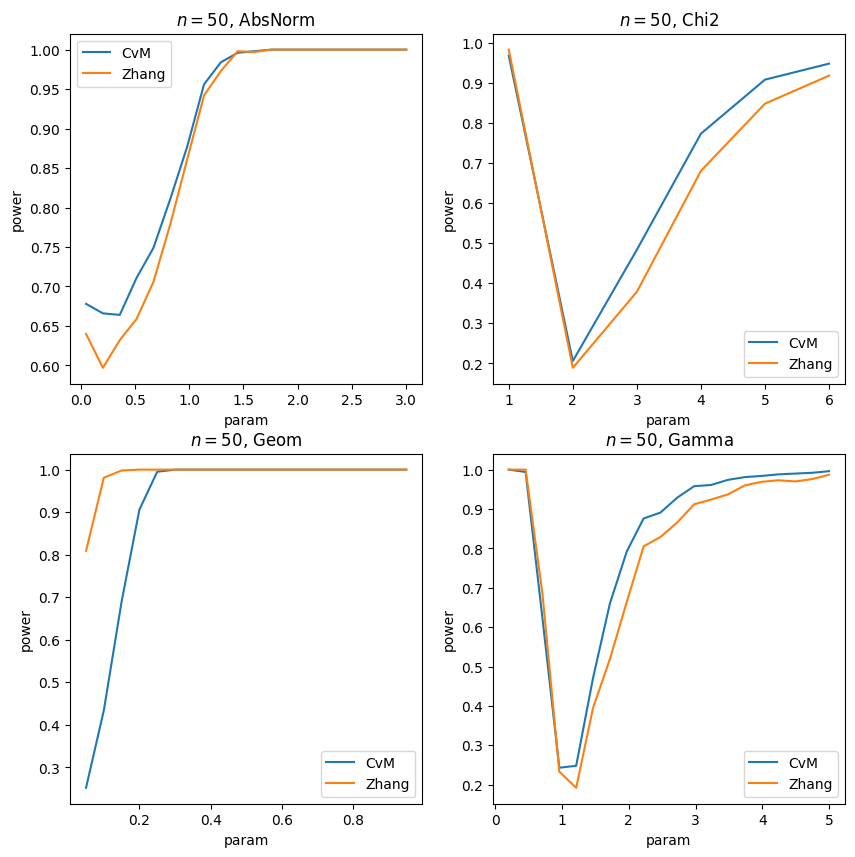

In [149]:
RVs = [(AbsNorm, np.linspace(0.05, 3, 20), 50, "AbsNorm"),
       (st.chi2, [1, 2, 3, 4, 5, 6], 50, "Chi2"),
       (st.geom, np.linspace(0.05, 0.95, 19), 50, "Geom"),
       (st.gamma, np.linspace(0.2, 5, 20), 50, "Gamma")]
K = 1000

ncols = 2
nrows = len(RVs) // ncols + (1 if len(RVs) % ncols else 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))

for (dist, grid, n, name), ax in zip(RVs, axes.ravel()):
    ax.set_title(fr"$n = {n}$, {name}")
    ax.set_xlabel("param")
    ax.set_ylabel("power")
    d = {"CvM": [], "Zhang": []}
    for param in grid:
        rv = dist(param)
        X = rv.rvs((K, n))
        pval = CvM_exp(X)
        power = (pval < alpha).mean()
        d["CvM"].append(power)
        pval = zhang_a(X)
        power = (pval < alpha).mean()
        d["Zhang"].append(power)
    for cr, power in d.items():
        ax.plot(grid, power, label=cr)
    ax.legend();